In [ ]:
pip install imbalanced-learn
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import csv
with open("data/processed_data.csv", "r", newline="", encoding="utf-8") as file:
    reader = csv.reader(file)
    header = next(reader)  
    num_entries = sum(1 for _ in reader) 
print("Number of entries in CSV:", num_entries)

Number of entries in CSV: 9525


In [2]:
import pandas as pd

df = pd.read_csv("data/processed_data.csv")
print(df['rating_star'].value_counts())

rating_star
2    4438
0    3123
1    1964
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

svm_param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"], 
    "gamma": ["scale", "auto"]  
}

rf_param_grid = {
    "n_estimators": [100, 200], 
    "max_depth": [10, 20, None],  
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]  
}

bb_param_grid = {
    "alpha": [0.1, 0.5, 1.0]  
}

df = pd.read_csv("data/processed_data.csv")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"], df["rating_star"], test_size=0.2, random_state=42, stratify=df["rating_star"]
)

vectorizer = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 3), 
    stop_words="english",  
    min_df=2,  
    max_df=0.9,  
)

X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)
X_train_resampled, train_labels_resampled = smote.fit_resample(X_train, train_labels)

svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
svm_grid.fit(X_train_resampled, train_labels_resampled)
best_svm = svm_grid.best_estimator_
print(f"Best SVM Parameters: {svm_grid.best_params_}")

rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train_resampled, train_labels_resampled)
best_rf = rf_grid.best_estimator_
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")

nb_grid = GridSearchCV(MultinomialNB(), bb_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
nb_grid.fit(X_train_resampled, train_labels_resampled)
best_nb = nb_grid.best_estimator_
print(f"Best Naïve Bayes Parameters: {nb_grid.best_params_}")

Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Naïve Bayes Parameters: {'alpha': 0.1}


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import numpy as np

svm_preds = best_svm.predict_proba(X_train_resampled)
rf_preds = best_rf.predict_proba(X_train_resampled)
nb_preds = best_nb.predict_proba(X_train_resampled)

meta_features_train = np.hstack((svm_preds, rf_preds, nb_preds))

param_grid = {
    "C": loguniform(0.001, 10),
    "solver": ["liblinear", "lbfgs", "saga"],
    "max_iter": [100, 200, 500, 1000],
}

meta_model = LogisticRegression(random_state=42)

random_search = RandomizedSearchCV(
    meta_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

random_search.fit(meta_features_train, train_labels_resampled)
best_meta_model = random_search.best_estimator_

print("Best Meta Model Parameters:", random_search.best_params_)
print("Best Meta Model Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Meta Model Parameters: {'C': np.float64(0.6367574915058981), 'max_iter': 100, 'solver': 'lbfgs'}
Best Meta Model Score: 0.9852582159624413


In [6]:
svm_preds_val = best_svm.predict_proba(X_val)
rf_preds_val = best_rf.predict_proba(X_val)
nb_preds_val = best_nb.predict_proba(X_val)

meta_features_val = np.hstack((svm_preds_val, rf_preds_val, nb_preds_val))

final_preds = best_meta_model.predict(meta_features_val)

from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(val_labels, final_preds)
print("Final Stacked Model Accuracy:", val_accuracy)

Final Stacked Model Accuracy: 0.7490813648293964


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE

df = pd.read_csv("data/processed_data.csv")


train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"], df["rating_star"], test_size=0.2, random_state=42, stratify=df["rating_star"]
)

vectorizer = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 3), 
    stop_words="english", 
    min_df=2,  
    max_df=0.9, 
)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)
X_train_resampled, train_labels_resampled = smote.fit_resample(X_train, train_labels)

svm_model = SVC(
    probability=True, 
    kernel="rbf",  
    C=10,  
    gamma="scale",  
    random_state=42
)
rf_model = RandomForestClassifier(
    n_estimators=200,  
    max_depth=None,  
    min_samples_split=5,  
    min_samples_leaf=1,
    random_state=42
)
nb_model = MultinomialNB(alpha=0.1)


svm_model.fit(X_train_resampled, train_labels_resampled)
rf_model.fit(X_train_resampled, train_labels_resampled)
nb_model.fit(X_train_resampled, train_labels_resampled)

svm_preds = svm_model.predict_proba(X_train_resampled)
rf_preds = rf_model.predict_proba(X_train_resampled)
bb_preds = nb_model.predict_proba(X_train_resampled)

meta_features_train = np.hstack((svm_preds, rf_preds, bb_preds))

meta_model = LogisticRegression(
    solver="lbfgs",  
    C=np.float64(0.6367574915058981), 
    max_iter=100, 
    random_state=42
)

meta_model.fit(meta_features_train, train_labels_resampled)

meta_train_preds = meta_model.predict_proba(meta_features_train)
train_loss = log_loss(train_labels_resampled, meta_train_preds)

print(f"Training Loss: {train_loss:.4f}")
print("Training Completed!")

Training Loss: 0.0547
Training Completed!


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss, confusion_matrix

svm_val_preds = svm_model.predict_proba(X_val)
rf_val_preds = rf_model.predict_proba(X_val)
nb_val_preds = nb_model.predict_proba(X_val)

meta_features_val = np.hstack((svm_val_preds, rf_val_preds, nb_val_preds))

val_preds_proba = meta_model.predict_proba(meta_features_val)
val_preds = np.argmax(val_preds_proba, axis=1)

val_loss = log_loss(val_labels, val_preds_proba)
accuracy = np.mean(val_preds == val_labels)
f1 = f1_score(val_labels, val_preds, average="weighted")
precision = precision_score(val_labels, val_preds, average="weighted")
recall = recall_score(val_labels, val_preds, average="weighted")
conf_matrix = confusion_matrix(val_labels, val_preds)

print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Val Loss: {val_loss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print(f"Final Precision: {precision:.4f}")
print(f"Final Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Final Training Loss: 0.0547
Final Val Loss: 0.8066
Final Accuracy: 0.7475
Final F1 Score: 0.7375
Final Precision: 0.7389
Final Recall: 0.7475

Confusion Matrix:
[[455  62 107]
 [ 83 172 138]
 [ 43  48 797]]


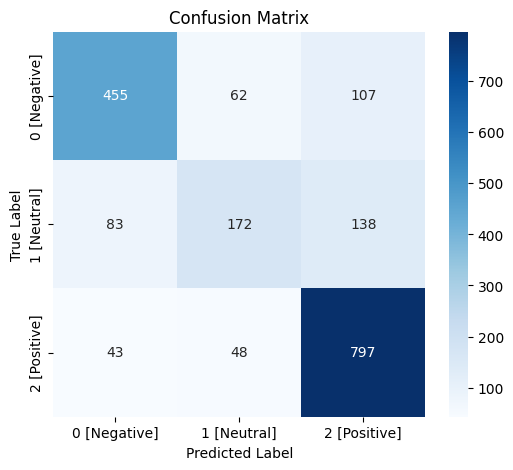

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["0 [Negative]", "1 [Neutral]", "2 [Positive]"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
import joblib

joblib.dump(meta_model, "data/meta_model.pkl")
joblib.dump(svm_model, "data/svm_model.pkl")
joblib.dump(rf_model, "data/rf_model.pkl")
joblib.dump(nb_model, "data/nb_model.pkl")
joblib.dump(vectorizer, "data/tfidf_vectorizer.pkl")

['data/tfidf_vectorizer.pkl']

In [ ]:
import joblib
import numpy as np

vectorizer = joblib.load("data/tfidf_vectorizer.pkl")
svm_model = joblib.load("data/svm_model.pkl")
rf_model = joblib.load("data/rf_model.pkl")
nb_model = joblib.load("data/nb_model.pkl")
meta_model = joblib.load("data/meta_model.pkl")

def predict_rating(input_text):
    input_vector = vectorizer.transform([input_text])

    svm_pred = svm_model.predict_proba(input_vector)
    rf_pred = rf_model.predict_proba(input_vector)
    nb_pred = nb_model.predict_proba(input_vector)

    meta_features = np.hstack((svm_pred, rf_pred, nb_pred))

    final_pred = meta_model.predict(meta_features)

    rating_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return rating_map[final_pred[0]]

user_text = input("Enter a review: ")
predicted_rating = predict_rating(user_text)

print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: Negative
